In [1]:
!pip install neural-tangents
!pip install chex

In [2]:
!pip install -q plotnine

In [3]:
!pip install -q git+https://github.com/deepmind/enn

In [24]:
import jax.numpy as jnp
from jax import random, jit, nn, vmap

import neural_tangents as nt
from neural_tangents import stax
from neural_tangents._src.utils import typing as nt_types

import numpy as np
import chex
from typing import Callable, List, Optional, Tuple, Union, Dict, NamedTuple
from typing import Sequence

import enn.base as enn_base
import enn.utils as enn_utils
from enn import supervised
from enn.supervised import base as supervised_base
from enn import networks
from enn import losses
from enn import utils
from enn import losses
from enn import networks
from enn import supervised
from enn import data_noise
from enn.networks import ensembles
from enn.networks import priors

import dataclasses
import functools

import pandas as pd
import matplotlib.pyplot as plt
import plotnine as gg

from acme.utils import loggers
from acme.utils.loggers.terminal import TerminalLogger

import haiku as hk
import jax
import optax
from jax import random, lax, jit

import chex
from sklearn.preprocessing import PolynomialFeatures

In [25]:
import jax.numpy as jnp
from jax import random, jit, nn, vmap

import neural_tangents as nt
from neural_tangents import stax
from neural_tangents._src.utils import typing as nt_types

import numpy as np
import chex
from typing import Callable, List, Optional, Tuple, Union

from sklearn.preprocessing import PolynomialFeatures

In [26]:
def make_linear_kernel(input_dim: int = 1) -> nt_types.AnalyticKernelFn:
  """Generate a linear GP kernel for testing putposes."""
  layers = [
      stax.Dense(1, W_std=1, b_std=1 / np.sqrt(input_dim)),
  ]
  _, _, kernel = stax.serial(*layers)
  return kernel

In [27]:
def make_random_poly_regression_environment(key: chex.PRNGKey,
                                            degree: int,
                                            ntrain: int,
                                            ntest: int,
                                            nout: int = 1,
                                            obs_noise: float = 0.01,
                                            kernel_ridge: float = 1e-6,
                                            x_train_generator: Callable = random.normal,
                                            x_test_generator: Callable = random.normal,
                                            ntk: bool = False,
                                            shuffle: bool = False):
    
    train_key, test_key, y_key, train_noise_key, test_noise_key = random.split(key, 5)

    X_train = x_train_generator(train_key, (ntrain, 1))
    X_test = x_test_generator(test_key, (ntest, 1))

    ntrain = len(X_train)
    ntest = len(X_test)

    X = jnp.vstack([X_train, X_test])

    poly = PolynomialFeatures(degree)
    Phi = jnp.array(poly.fit_transform(X), dtype=jnp.float32)

    N = ntrain + ntest
    get_kernel = 'ntk' if ntk else 'nngp'
    input_dim = X.shape[-1]
    kernel_fn = make_linear_kernel(input_dim)
    kernel = kernel_fn(X, x2=None, get=get_kernel)
    kernel += kernel_ridge * jnp.eye(len(kernel))
    mean = jnp.zeros((N,), dtype=jnp.float32)
    y_function = random.multivariate_normal(y_key, mean, kernel)
    print(y_function)
    chex.assert_shape(y_function[:ntrain], [ntrain,])

    # Form the training data
    y_noise = random.normal(train_noise_key, [ntrain, 1]) * obs_noise
    y_train = y_function[:ntrain, None] + y_noise

    X_train = Phi[:ntrain]
    X_test = Phi[ntrain:]

    y_noise = random.normal(test_noise_key, [ntest, 1]) * obs_noise
    y_test = y_function[ntrain:, None] + y_noise

    # Form the posterior prediction at cached test data
    predict_fn = nt.predict.gradient_descent_mse_ensemble(
        kernel_fn, X_train, y_train, diag_reg=(obs_noise))
    _test_mean, _test_cov = predict_fn(
        t=None, x_test=X_test, get='nngp', compute_cov=True)
    _test_cov += kernel_ridge * jnp.eye(ntest)

    chex.assert_shape(_test_mean, [ntest, 1])
    chex.assert_shape(_test_cov, [ntest, ntest])
    

    if shuffle:
        train_key, test_key = random.split(key)
        train_indices = random.permutation(train_key,
                                           jnp.arange(ntrain))
        test_indices = random.permutation(test_key,
                                          jnp.arange(ntest))

        X_train = X_train[train_indices]
        y_train = y_train[train_indices]

        X_test = X_test[test_indices]
    
    return (X_train, y_train), (X_test, y_test)

In [28]:
def make_gaussian_sampler(loc: Union[chex.Array, float],
                          scale: Union[chex.Array, float]):
    def gaussian_sampler(key: chex.PRNGKey, shape: Tuple) -> chex.Array:
        return loc + scale * random.normal(key, shape)

    return gaussian_sampler


def make_evenly_spaced_x_sampler(max_val: float, use_bias: bool = True, min_val: float = 0) -> Callable:
    def eveny_spaced_x_sampler(key: chex.PRNGKey, shape: Tuple) -> chex.Array:
        if len(shape) == 1:
            shape = (shape[0], 1)
        nsamples, nfeatures = shape
        assert nfeatures == 1 or nfeatures == 2

        if nfeatures == 1:
            X = jnp.linspace(min_val, max_val, nsamples)
            if use_bias:
                X = jnp.c_[jnp.ones(nsamples), X]
            else:
                X = X.reshape((-1, 1))
        else:
            step_size = (max_val - min_val) / float(nsamples)
            # define the x and y scale
            x = jnp.arange(min_val, max_val, step_size)
            y = jnp.arange(min_val, max_val, step_size)

            # create all of the lines and rows of the grid
            xx, yy = jnp.meshgrid(x, y)

            # flatten each grid to a vector
            r1, r2 = xx.flatten(), yy.flatten()
            r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
            # horizontal stack vectors to create x1,x2 input for the model
            X = jnp.hstack((r1, r2))
        return X

    return eveny_spaced_x_sampler

In [29]:
key = random.PRNGKey(0)

min_val, max_val = -0.6, 0.6
scale = 1.

x_train_generator = make_gaussian_sampler(0, scale)

min_val, max_val = -1, 1
x_test_generator = make_evenly_spaced_x_sampler(max_val,
                                                use_bias=False,
                                                min_val=min_val)

degree = 3
ntrain = 12
ntest = 12
batch_size = 3
obs_noise = 0.1



train_data, test_data = make_random_poly_regression_environment(key,
                                                                degree,
                                                                ntrain,
                                                                ntest,
                                                                obs_noise=obs_noise,
                                                                x_train_generator=x_train_generator,
                                                                x_test_generator=x_test_generator,
                                                                shuffle=True)

[-0.35613957 -0.13946246  0.58031756 -0.01819176 -0.00990052  0.2805578
 -0.25247058  0.06397428 -0.5336115  -0.05558515 -0.18045126 -0.09633398
 -0.7831938  -0.6879381  -0.593395   -0.500929   -0.40665185 -0.31033573
 -0.21433873 -0.12018804 -0.02539196  0.06761484  0.16279405  0.2575671 ]


In [30]:
x, y = train_data
#x, y = test_data

In [31]:
def make_dataset(key: chex.PRNGKey = random.PRNGKey(0),
                 n: int = 100,
                 minval: float = -1.,
                 maxval: float = 1.) -> enn_base.BatchIterator:
  """Factory method to produce an iterator of Batches."""
  
  data = enn_base.Batch(
      x=x,
      y=y,
  )

  return utils.make_batch_iterator(data)

In [32]:
n = 100
minval, maxval = 0.0, 0.5
key = random.PRNGKey(0)
dataset = make_dataset(key,
                      n,
                      minval,
                      maxval)

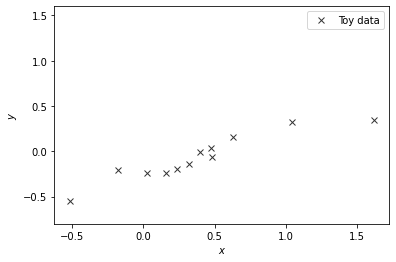

In [33]:
# Plot the generated data
plt.figure() #figsize=[12,6], dpi=200)
plt.plot(x[:, 1], y, 'kx', label='Toy data', alpha=0.8)

#plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel('$x$')
plt.ylabel('$y$')
#plt.xlim(-0.5,1.0)
plt.ylim(-0.8,1.6)
plt.legend();
plt.show()

In [34]:
@dataclasses.dataclass
class Config:
  num_batch: int = 2_000
  index_dim: int = 1
  num_index_samples: int = 10
  seed: int = 0
  prior_scale: float = 3.
  learning_rate: float = 0.03
  noise_std: float = 0.1

FLAGS = Config()

In [35]:
class MLPEnsembleMatchedPrior(enn_base.EpistemicNetwork):
  """Ensemble of MLPs with matched prior functions."""

  def __init__(
      self,
      output_sizes: Sequence[int],
      dummy_input: enn_base.Array,
      num_ensemble: int,
      prior_scale: float = 1.,
      seed: int = 0,
      w_init: Optional[hk.initializers.Initializer] = None,
      b_init: Optional[hk.initializers.Initializer] = None,
      activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
  ):
    """Ensemble of MLPs with matched prior functions."""
    mlp_priors = ensembles.make_mlp_ensemble_prior_fns(
        output_sizes, dummy_input, num_ensemble, seed)

    def net_fn(x: enn_base.Array) -> enn_base.Array:
      x = hk.Flatten()(x)
      return hk.nets.MLP(output_sizes, w_init, b_init, activation=activation)(x)
    transformed = hk.without_apply_rng(hk.transform(net_fn))

    ensemble = ensembles.Ensemble(transformed, num_ensemble)
    enn = priors.EnnWithAdditivePrior(
        enn=ensemble,
        prior_fn= ensembles.combine_functions_choice_via_index(mlp_priors),
        prior_scale=prior_scale,
    )
    super().__init__(enn.apply, enn.init, enn.indexer)

In [36]:
*_, nfeatures = x.shape
dummy_input = jnp.ones((n, nfeatures))
output_sizes = [16, 16, 1]

# Create Ensemble ENN with a prior network 
enn = MLPEnsembleMatchedPrior(
    output_sizes=output_sizes,
    dummy_input=dummy_input,
    num_ensemble=FLAGS.index_dim,
    prior_scale=FLAGS.prior_scale,
    seed=FLAGS.seed,
    # use glorot normal as a kernel initializer
    w_init=hk.initializers.VarianceScaling(1.0, "fan_avg", "truncated_normal"), 
    activation = nn.elu
)

In [37]:
# Optimizer
optimizer = optax.adam(FLAGS.learning_rate)

In [38]:
# L2 loss on perturbed outputs 
single_loss = losses.L2Loss()
loss_fn = losses.average_single_index_loss(single_loss, FLAGS.num_index_samples)

In [39]:
# Logger
logger = TerminalLogger('supervised_regression')

# Aggregating different components of the experiment
experiment = supervised.Experiment(
    enn, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

In [40]:
# Train the experiment
experiment.train(FLAGS.num_batch)

In [41]:
def make_regression_df(key: chex.PRNGKey = random.PRNGKey(0),
                 n: int = 100,
                 minval: float = -1.,
                 maxval: float = 1.) -> pd.DataFrame:
  """Generate a panda dataframe with sampled predictions."""
  
  return pd.DataFrame({'x': x[:, 1], 'y': y[:, 0]}).reset_index()

In [42]:
def make_plot_data(experiment: supervised.BaseExperiment,
                   num_sample: int = 20) -> pd.DataFrame:
  """Generate a panda dataframe with sampled predictions."""
  preds_x = np.linspace(-0.5, 2.).reshape((-1, 1))
  preds_x = PolynomialFeatures(degree).fit_transform(preds_x)
  
  data = []
  rng = hk.PRNGSequence(random.PRNGKey(seed=0))
  for k in range(num_sample):
    net_out = experiment.predict(preds_x, key=next(rng))
    preds_y = utils.parse_net_output(net_out)

    
    data.append(pd.DataFrame({'x': preds_x[:, 1], 'y': preds_y[:, 0], 'k': k}))
  plot_df = pd.concat(data)
  return plot_df

In [43]:
def make_plot(experiment: supervised.BaseExperiment,
              num_sample: int = 20,
              dataset_kwargs: Dict = {}) -> gg.ggplot:
  """Generate a regression plot with sampled predictions."""
  
  plot_df = make_plot_data(
      experiment, num_sample=num_sample)

  p = (gg.ggplot()
       + gg.aes('x', 'y')
       + gg.geom_point(data=make_regression_df(**dataset_kwargs), size=3, colour='blue')
       + gg.geom_line(gg.aes(group='k'), data=plot_df, alpha=0.5)
      )

  return p

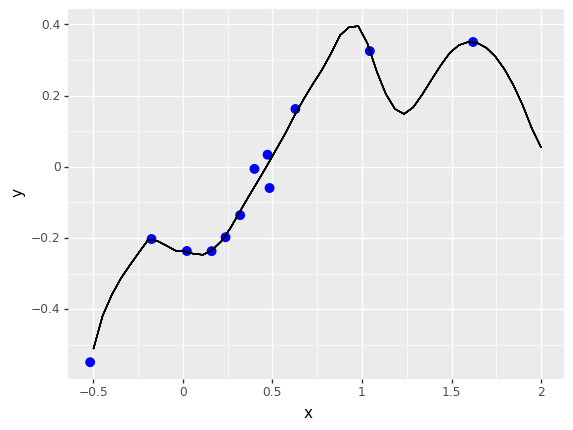

In [44]:
dataset_kwargs = { "n": n,
                    "minval" : minval,
                    "maxval" : maxval,
                    "key" : random.PRNGKey(0)}

p = make_plot(experiment,
              dataset_kwargs=dataset_kwargs)
_ = p.draw()

In [45]:
grid = jnp.linspace(-5, 5, 1000).reshape(-1, 1)
x_grid = PolynomialFeatures(degree).fit_transform(grid)

indexer = experiment.enn.indexer
params = experiment.state.params

index_key, key = random.split(key)
output_with_prior = experiment.enn.apply(params, x_grid, indexer(index_key))
y_model = output_with_prior.prior + output_with_prior.train

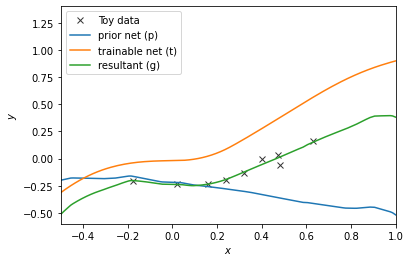

In [46]:
# Plot the results
plt.figure() #figsize=[12,6], dpi=200)
plt.plot(x[:, 1], y, 'kx', label='Toy data', alpha=0.8)
plt.plot(grid, output_with_prior.prior, label='prior net (p)')
plt.plot(grid, output_with_prior.train, label='trainable net (t)')
plt.plot(grid, y_model, label='resultant (g)')
#plt.title('Predictions of the prior network: random function')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-0.6,1.4)
plt.legend();

plt.savefig('randomized_priors_single_model.pdf')  
plt.savefig('randomized_priors_single_model.png') 

plt.show()

## Bootstrapped Ensembles

To implement bootstrapping using JAX, we generate a random map from seed values to dataset index values: $\{\text{seed}, \text{seed}+1 \dots, \text{seed}+99\} \to \{ 0, 1, \dots, 99 \}$ by utilizing ``` jax.random.randint ```  using a randomly-generated seed. We assume the random key space is large enough that we need not be concerned with generating overlapping seed ranges.

### Configuration

In [47]:
@dataclasses.dataclass
class Config:
  num_batch: int = 3_000
  index_dim: int = 8
  num_index_samples: int = 8
  seed: int = 0
  prior_scale: float = 3.
  learning_rate: float = 0.03
  noise_std: float = 0.
  distribution: str = "uniform"

FLAGS = Config()

### Dataset Initialization

In [48]:
n = 100
minval, maxval = 0.0, 0.5
key = random.PRNGKey(0)
dataset = make_dataset(key,
                      n,
                      minval,
                      maxval)

In [49]:
dummy_input = jnp.ones((n, nfeatures))
output_sizes = [16, 16, 1]

# Create Ensemble ENN with a prior network 
enn = MLPEnsembleMatchedPrior(
    output_sizes=output_sizes,
    dummy_input=dummy_input,
    num_ensemble=FLAGS.index_dim,
    prior_scale=FLAGS.prior_scale,
    seed=FLAGS.seed,
    #use glorot normal as a kernel initializer
    w_init=hk.initializers.VarianceScaling(1.0, "fan_avg", "truncated_normal"), 
    activation = nn.elu
)

In [50]:
# Add bootstrapping
boot_fn = data_noise.BootstrapNoise(enn, FLAGS.distribution)
single_loss = losses.add_data_noise(losses.L2Loss(), boot_fn)
loss_fn = losses.average_single_index_loss(single_loss, FLAGS.num_index_samples)

In [51]:
# Aggregating different components of the experiment
experiment = supervised.Experiment(
    enn, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

In [52]:
experiment.train(FLAGS.num_batch)

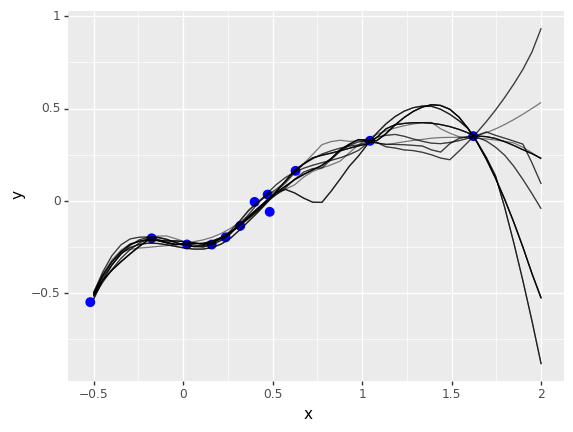

In [53]:
dataset_kwargs = { "n": n,
                    "minval" : minval,
                    "maxval" : maxval,
                    "key" : random.PRNGKey(0)}

p = make_plot(experiment,
              dataset_kwargs=dataset_kwargs)
_ = p.draw()

In [54]:
def get_predictions(params, index):
  output_with_prior = experiment.enn.apply(params, x_grid, index)
  return output_with_prior.prior, output_with_prior.train

params = experiment.state.params
indices = jnp.arange(FLAGS.index_dim)
y_priors, y_trains = vmap(get_predictions, in_axes=(None, 0))(params, indices)

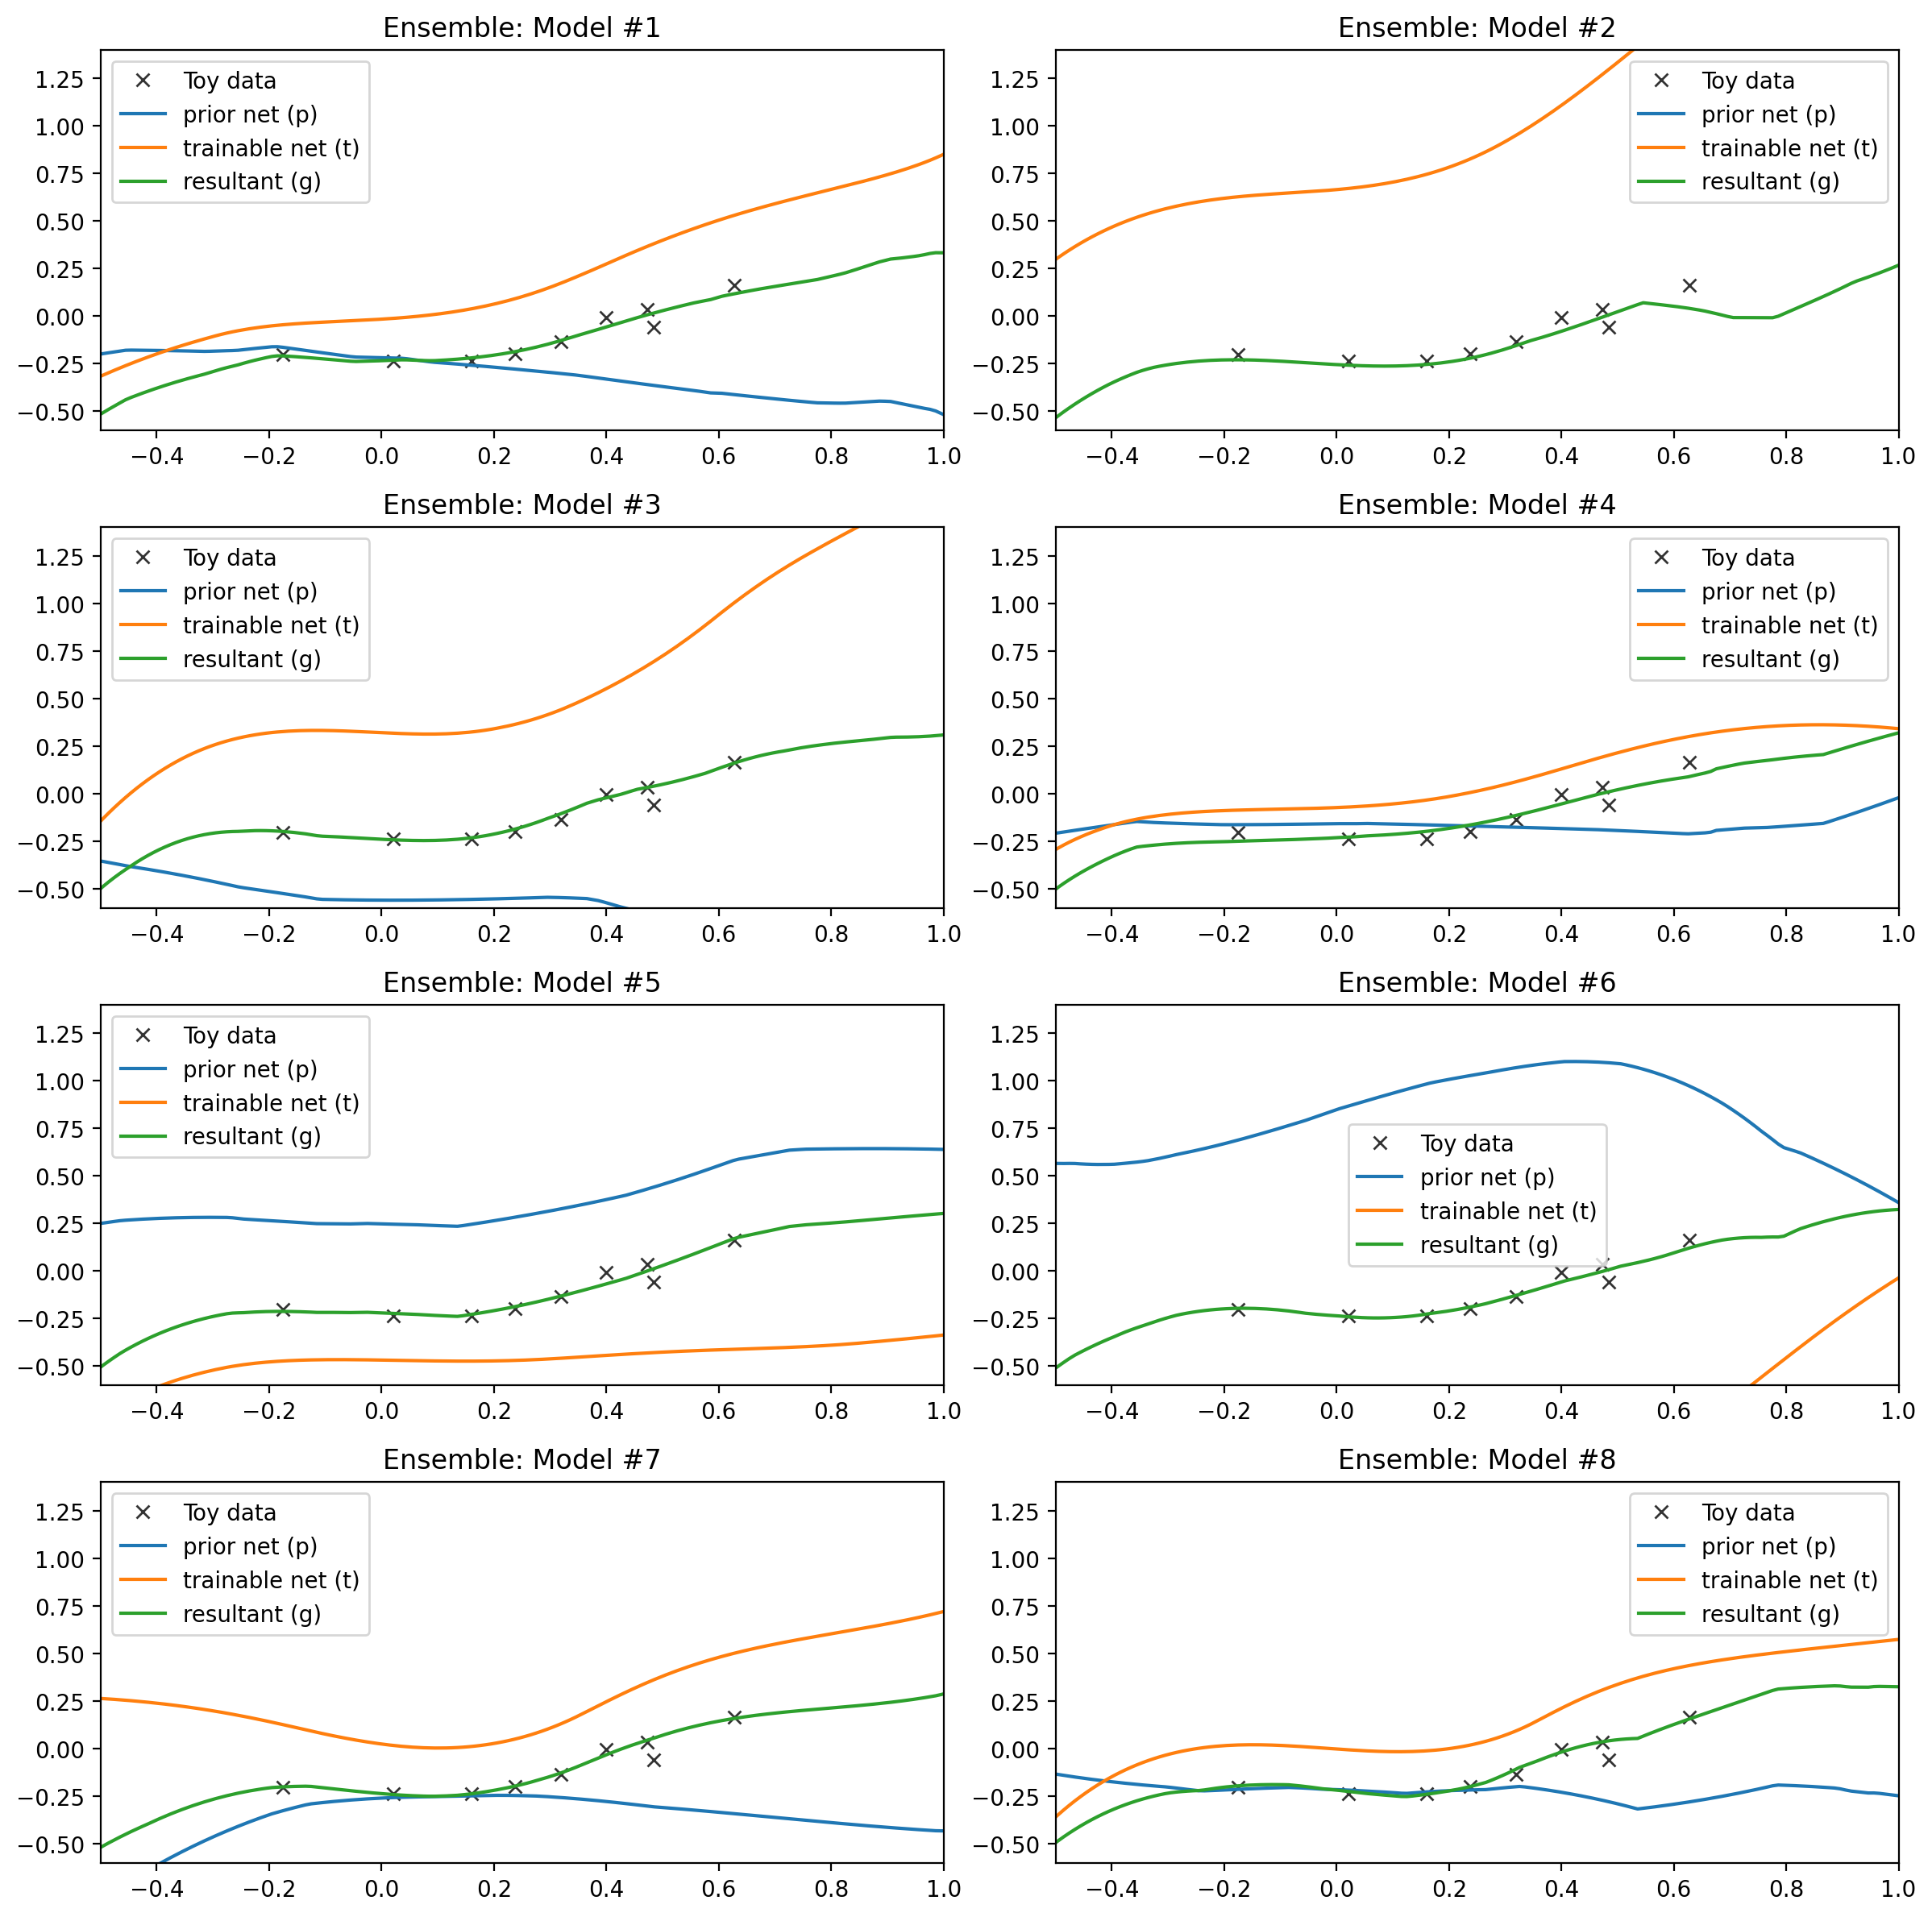

In [55]:
# Plot the results
plt.figure(figsize=(12, 12), dpi=200)

for i, (y_prior, y_train) in enumerate(zip(y_priors, y_trains)):
    plt.subplot(4, 2, i+1)
    plt.plot(x[:, 1], y, 'kx', label='Toy data', alpha=0.8)
    plt.plot(grid, y_prior, label='prior net (p)')
    plt.plot(grid, y_train, label='trainable net (t)')
    plt.plot(grid, y_prior + y_train, label='resultant (g)')
    plt.title('Ensemble: Model #{}'.format(i+1))
    plt.xlim(-0.5,1.0)
    plt.ylim(-0.6,1.4)
    plt.legend()

plt.tight_layout()

plt.savefig('randomized_priors_multi_model.pdf')  
plt.savefig('randomized_priors_multi_model.png') 
plt.show();